In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="geologymodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
geologyFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
geologyFOSID = geologyFOSID.filter(geologyFOSID["Domain"]=="Geology").collect()

In [8]:
len(geologyFOSID)

170

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])


In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(geologyFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+--------+-------+
|  FOS_ID| Domain|
+--------+-------+
|16674752|Geology|
|17409809|Geology|
+--------+-------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

3134494

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [19]:
(sample1,sample2) = papers_filtered1.randomSplit([0.3,0.5])

In [20]:
sample1.count()

1174214

In [21]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [22]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             0|
|             2|
|             1|
|             0|
+--------------+
only showing top 4 rows



In [23]:
sample1_pd = sample1.toPandas()

In [24]:
import numpy as np

In [25]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [26]:
from sklearn import metrics

In [27]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 1.9758996230670047)
('Mean Squared Error of EstimatedCount:', 489.38077982378)
('Root Mean Squared of with EstimatedCount:', 22.121952441495303)


In [28]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [29]:
sample1_pd.shape

(1174214, 12)

In [30]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [31]:
from sklearn.model_selection import KFold

In [32]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 3.583812598045285)
('Mean Squared Error:', 259.49864154111236)
('Root Mean Squared Error:', 16.108961528947557)
('Mean Absolute Error:', 3.6039770749499875)
('Mean Squared Error:', 326.64911840622915)
('Root Mean Squared Error:', 18.073436817778436)
('Mean Absolute Error:', 2.608944294029845)
('Mean Squared Error:', 168.92063396879067)
('Root Mean Squared Error:', 12.996947101869372)
('Mean Absolute Error:', 1.0606668458605253)
('Mean Squared Error:', 61.769731144269244)
('Root Mean Squared Error:', 7.859372185121993)
('Mean Absolute Error:', 0.3824399996624262)
('Mean Squared Error:', 46.962041051747356)
('Root Mean Squared Error:', 6.852885600369187)


In [37]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 12.378320646817308)


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
featureslist=sample1_pd.columns

In [40]:
importances = regressor.feature_importances_

In [41]:
import pandas as pd

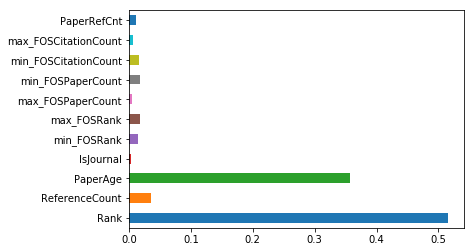

In [42]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

## XGBoost Regression model

In [43]:
import xgboost as xgb

In [44]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [45]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 234843,  234844,  234845, ..., 1174211, 1174212, 1174213]), 'TEST:', array([     0,      1,      2, ..., 234840, 234841, 234842]))
('Mean Absolute Error of XGBoost Kfold:', 3.8213199731529692)
('Mean Squared Error of XGBoost Kfold:', 288.72993180727036)
('Root Mean Squared Error of XGBoost Kfold:', 16.99205496128324)
('TRAIN:', array([      0,       1,       2, ..., 1174211, 1174212, 1174213]), 'TEST:', array([234843, 234844, 234845, ..., 469683, 469684, 469685]))
('Mean Absolute Error of XGBoost Kfold:', 3.779020795636134)
('Mean Squared Error of XGBoost Kfold:', 361.72007086183567)
('Root Mean Squared Error of XGBoost Kfold:', 19.018939793317493)
('TRAIN:', array([      0,       1,       2, ..., 1174211, 1174212, 1174213]), 'TEST:', array([469686, 469687, 469688, ..., 704526, 704527, 704528]))
('Mean Absolute Error of XGBoost Kfold:', 2.6928857227777407)
('Mean Squared Error of XGBoost Kfold:', 188.26086622327756)
('Root Mean Squared Error of XGBoost Kfold:', 13.72

In [46]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 13.301654372581305)


In [47]:
importances = regressor.feature_importances_

In [48]:
import pandas as pd

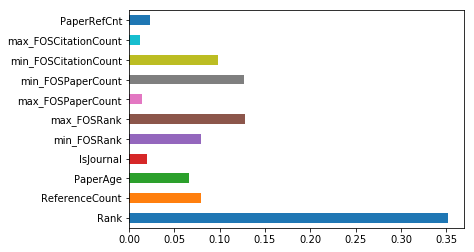

In [49]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [50]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.35165
Feature: 1, Score: 0.07920
Feature: 2, Score: 0.06599
Feature: 3, Score: 0.01974
Feature: 4, Score: 0.07985
Feature: 5, Score: 0.12774
Feature: 6, Score: 0.01490
Feature: 7, Score: 0.12694
Feature: 8, Score: 0.09848
Feature: 9, Score: 0.01220
Feature: 10, Score: 0.02329
